MULTIVARIATE NORMAL MODEL
$$
\theta \sim \mathcal{N}\!\left(\mu_{\text{prior}}, \sigma_{\text{prior}}^2 I_D\right),
$$

$$
y_i \mid \theta \sim \mathcal{N}\!\left(\theta, \sigma_{\text{lik}}^2 I_D\right),
\quad i = 1, \dots, K.
$$

(A). Given observations $\mathbf{y} = \{y_1,\dots,y_K\}$, the analytical posterior is Gaussian:

$$
p(\theta \mid \mathbf{y})
= \mathcal{N}\!\left(\mu_{\text{post}}, \Sigma_{\text{post}}\right),
$$

with posterior covariance

$$
\Sigma_{\text{post}}
= \left(
\frac{K}{\sigma_{\text{lik}}^2} I_D
+ \frac{1}{\sigma_{\text{prior}}^2} I_D
\right)^{-1},
$$

and posterior mean

$$
\mu_{\text{post}}
= \Sigma_{\text{post}}
\left(
\frac{K}{\sigma_{\text{lik}}^2} \bar{y}
+ \frac{1}{\sigma_{\text{prior}}^2} \mu_{\text{prior}}
\right),
$$

where $\bar{y} = \frac{1}{K}\sum_{i=1}^K y_i$ denotes the sample mean.


(B). The marginal likelihood (model evidence) admits a closed-form expression:

$$
\begin{aligned}
\log p(\mathbf{y})
=& -\frac{KD}{2}\log(2\pi)
   -\frac{D}{2}\log\!\left(\sigma_{\text{lik}}^2\right)
   -\frac{D}{2}\log\!\left(
      \sigma_{\text{prior}}^2
      + \frac{\sigma_{\text{lik}}^2}{K}
   \right) \\
 & -\frac{K}{2\sigma_{\text{lik}}^2}
   \sum_{i=1}^K
   \lVert y_i - \bar{y} \rVert^2 \\
 & -\frac{K}{2\left(\sigma_{\text{lik}}^2
   + K\sigma_{\text{prior}}^2\right)}
   \lVert \bar{y} - \mu_{\text{prior}} \rVert^2 .
\end{aligned}
$$

(C). Using neural posterior estimation (NPE), we approximate the posterior

$p(\theta \mid \mathbf{y})$ with a neural density estimator
$q_\phi(\theta \mid \mathbf{y})$.

Following Bayes' theorem, the marginal likelihood can be rewritten as

$$
\log p(\mathbf{y})
=
\log p(\theta)
+ \log p(\mathbf{y} \mid \theta)
- \log p(\theta \mid \mathbf{y}).
$$

Replacing the true posterior with the neural approximation
$q_\phi(\theta \mid \mathbf{y})$ yields the estimator

$$
\log p(\mathbf{y})
\approx
\log
\mathbb{E}_{\theta \sim q_\phi(\theta \mid \mathbf{y})}
\left[
\exp\!\Big(
\log p(\theta)
+ \log p(\mathbf{y} \mid \theta)
- \log q_\phi(\theta \mid \mathbf{y})
\Big)
\right].
$$
In practice, the expectation is approximated using Monte Carlo samples
$\{\theta^{(s)}\}_{s=1}^S \sim q_\phi(\theta \mid \mathbf{y})$:

$$
\log p(\mathbf{y})
\approx
\log \frac{1}{S}
\sum_{s=1}^S
\exp\!\Big(
\log p(\theta^{(s)})
+ \log p(\mathbf{y} \mid \theta^{(s)})
- \log q_\phi(\theta^{(s)} \mid \mathbf{y})
\Big).
$$

1. Set Up

In this case study, I considered a 2-dimensional multivariate normal model, with  $ \mu_{prior}=0$ and $
\sigma_{prior}=1$, here, set $\sigma_{lik}=K$ so that the total information in $Y$ remains constant, independent of $K$, which simplifies comparisons across observations of varying number of data points.
For simplicity, set $K=10$.

2. OOD Evaluation

To assess robustness under OOD settings,  I generate observation data sets with varying means $\mu_{obs}={0,1,5,8}$. Posterior and marginal likelihood accuracy are evaluated by visualizing the MMD.

3. Netwrok Architectures

Summary network: Deepset architecture with 30 summary dimensions, ReLU activation function, and mean pooling, 2 dense layers with 64 units as default in Bayesflow.

Inference network: Neural spline coupling flow, composed of 5 invertible layers of width 128, ReLU activation and a drop out rate of 0.05 and a multivariate unit Gaussian base distribution. 

All networks are optimized using the Adam optimizer. Training is performed for 100 epchos with batch size of 32 and learning rate of $10^{-3}$ with training budget N=6000.

4. Main results: 

    1. The simulation-based training converged.
    2. SBC showed approximately uniform distribution. ECDF and Accuracy looks good.
    3. The MMD grows with increasing distance of the observed data from the prior mean, indicating that the NPE posterior approximation degrades for more OOD data.
    4. While NPE yields accurate marginal likelihood estimates in-distribution, evidence estimation becomes increasingly unstable under stronger OOD shifts, highlighting the sensitivity of marginal likelihoods to posterior approximation errors.


In [1]:
import os

if "KERAS_BACKEND" not in os.environ:
    # set this to "torch", "tensorflow", or "jax"
    os.environ["KERAS_BACKEND"] = "jax"

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import keras
import bayesflow as bf

INFO:bayesflow:Using backend 'jax'


In [3]:
RNG = np.random.default_rng(2025)

In [4]:
D=2         # dimensionality of the data
K=10        # number of observations

In [5]:
def prior():
    # generate a random draw from the prior
    mu=RNG.normal(0,1,size=D)
    return dict(mu=mu)

In [6]:
prior_draw=prior()
print(prior_draw['mu'].shape)
print(prior_draw["mu"])

(2,)
[-2.22125388  0.02599965]


In [7]:
def likelihood(mu,K=K):
    # generate a random dataset given parameters
    x=RNG.normal(loc=mu, scale=np.sqrt(K), size=(K,D))
    return dict(x=x,K=K)

In [8]:
data_draws=likelihood(mu=0,K=K)
print(data_draws['x'].shape)
print(data_draws["x"])

(10, 2)
[[-1.70436969 -3.57082109]
 [-7.72186034  2.42038014]
 [-2.40241189  0.8443161 ]
 [ 2.21922591  0.92376871]
 [-0.62642533  2.08321765]
 [ 1.64424977  1.89424043]
 [-5.22275755 -1.24100646]
 [-2.14186429  9.28448125]
 [-2.10173583  3.97644856]
 [-5.31612779 -1.26356223]]


In [9]:
simulator=bf.make_simulator([prior, likelihood])

In [10]:
test_sims=simulator.sample(5)
print(test_sims['mu'].shape)
print(test_sims['x'].shape)

(5, 2)
(5, 10, 2)


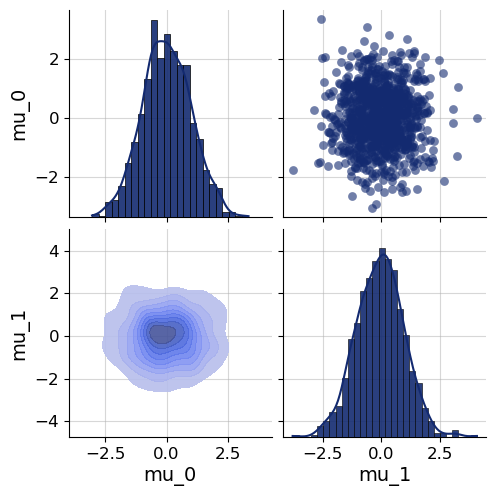

In [11]:
# prior checking
prior_samples=simulator.simulators[0].sample(1000)
grid=bf.diagnostics.plots.pairs_samples(prior_samples,variable_keys=['mu'])

In [12]:
adapter=(
    bf.adapters.Adapter()
    .convert_dtype("float64","float32")
    .broadcast("K",to="mu")
    .rename('mu','inference_variables')
    .rename('x','summary_variables')
    .rename("K","inference_conditions")
)

In [13]:
adapted_sims=adapter(simulator.sample(5))
print(adapted_sims['inference_variables'].shape)
print(adapted_sims['summary_variables'].shape)

(5, 2)
(5, 10, 2)


In [14]:
# Define the summary network
summary_net = bf.networks.DeepSet(summary_dim=30,activation='relu')

In [15]:
inference_net=bf.networks.CouplingFlow(depth=5,transform="spline",
                                       subnet_kwargs=dict(widths=(128,128),activation='relu',dropout=0.05))

In [16]:
workflow=bf.BasicWorkflow(
    simulator=simulator,
    adapter=adapter,
    summary_network=summary_net,
    inference_network=inference_net,
    standardize=None)
workflow.approximator.compile(
    optimizer = keras.optimizers.Adam(1e-3)
)

In [17]:
%%time
_ = workflow.simulate(32)

CPU times: user 1.73 ms, sys: 1.61 ms, total: 3.34 ms
Wall time: 2.48 ms


In [18]:
training_data = workflow.simulate(6000)
validation_data = workflow.simulate(300)

In [19]:
history = workflow.fit_online(
    data=training_data, 
    epochs=100, 
    batch_size=32, 
    learning_rate=1e-3,
    validation_data=validation_data
)

INFO:bayesflow:Fitting on dataset instance of OnlineDataset.
INFO:bayesflow:Building on a test batch.


Epoch 1/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - loss: 2.5821 - val_loss: 2.3489
Epoch 2/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 2.5151 - val_loss: 2.4107
Epoch 3/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 2.5203 - val_loss: 2.5721
Epoch 4/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 2.5258 - val_loss: 2.5364
Epoch 5/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 2.4778 - val_loss: 2.3999
Epoch 6/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2.3968 - val_loss: 2.3998
Epoch 7/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 2.3251 - val_loss: 2.3608
Epoch 8/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2.3776 - val_loss: 2.3714
Epoch 9/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 2.3013 - val_loss: 2.3322
Epoch 10/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 2.3165 - val_loss: 2.4516
Epoch 11/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 2.3065 - val_loss: 2.3087
Epoch 12/100
100/100 ━━━━━━━━━

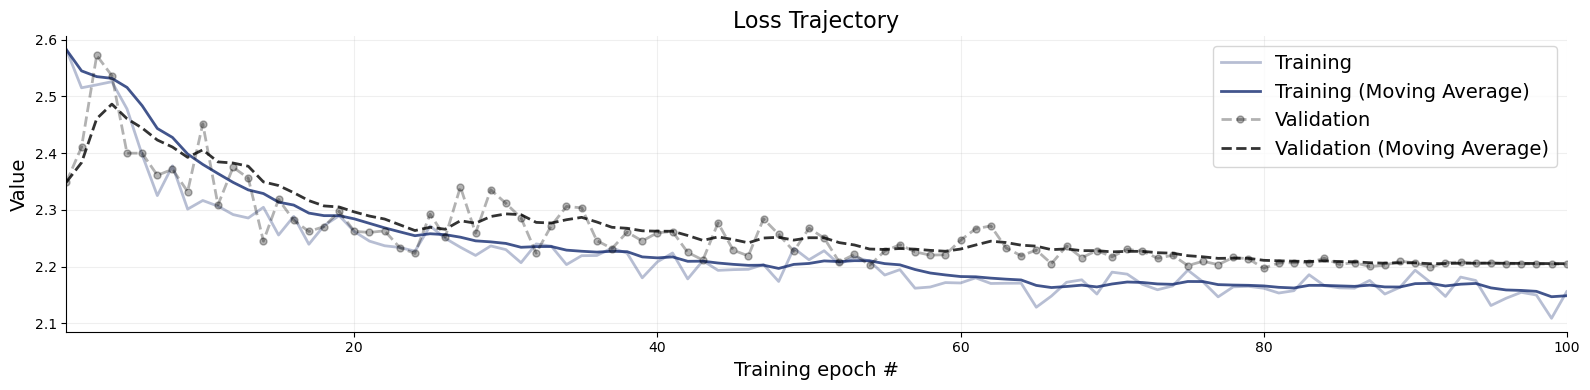

In [20]:
f = bf.diagnostics.plots.loss(history)

The approximator converged.

In [21]:
num_datasets = 300 # number of datasets to simulate
num_samples = 1000 # number of samples per dataset
test_sims = workflow.simulate(num_datasets) # simulate 300 test datasets
samples=workflow.approximator.sample(conditions=test_sims, num_samples=num_samples) # generate 1000 posterior samples per dataset

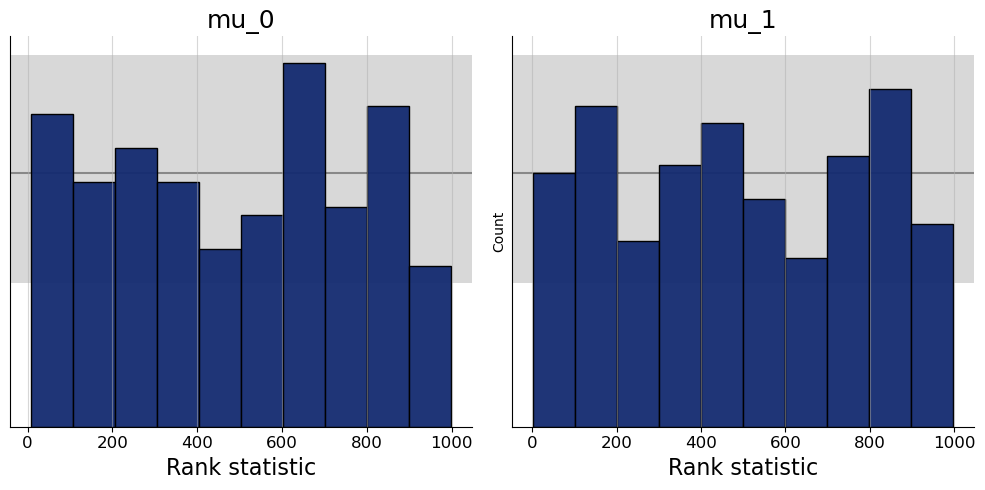

In [22]:
f = bf.diagnostics.plots.calibration_histogram(samples, test_sims)

Rank: Approximately uniform distributed.

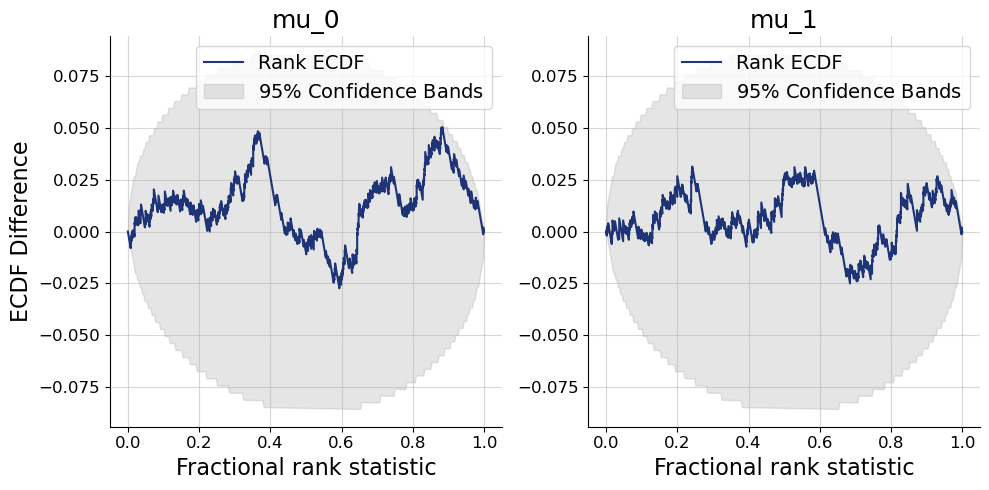

In [23]:
f = bf.diagnostics.plots.calibration_ecdf(samples, test_sims, difference=True)

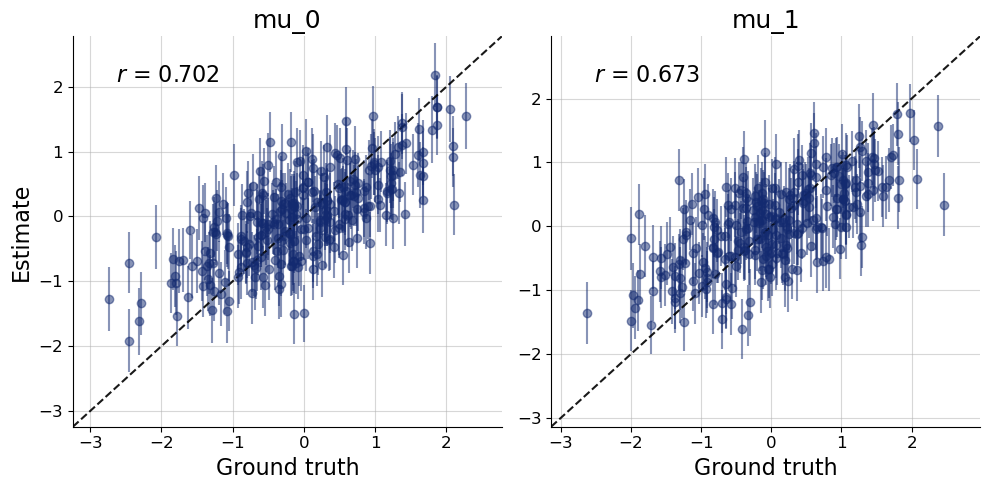

In [24]:
f = bf.diagnostics.plots.recovery(samples, test_sims)

Have been learned properly.

In [25]:
# Define the analytical posterior, with prior mean 0 and prior std 1
def analytical_posterior(obs_data,mu_prior_mean=0,mu_prior_std=1,likelihood_std=np.sqrt(K)):
    x_bar=np.mean(obs_data,axis=0)
    mu_post_var = 1 / (K / (likelihood_std ** 2) + 1 / (mu_prior_std ** 2))
    mu_post_mean = mu_post_var * (K* x_bar / (likelihood_std ** 2) + 1 * mu_prior_mean/ (mu_prior_std ** 2))
    return mu_post_mean, np.sqrt(mu_post_var)

In [26]:
# Define kernel function for MMD
def _rbf_kernel(X, Y, gamma):
    # X: (n, d), Y: (m, d)
    # in this case X:(1000,2), Y:(1000,2)
    X2 = np.sum(X**2, axis=1, keepdims=True)
    Y2 = np.sum(Y**2, axis=1, keepdims=True)
    dist2 = X2 - 2 * (X @ Y.T) + Y2.T
    ker_dist2 = np.exp(-gamma * dist2)
    return ker_dist2

def mmd_rbf_median_heuristic(X, Y, eps=1e-12):
    """
    Biased MMD^2 with RBF kernel.
    Uses median heuristic for bandwidth:
      gamma = 1 / (2 * median(dist^2))
    """
    X = np.asarray(X, dtype=np.float64)
    Y = np.asarray(Y, dtype=np.float64)

    # median heuristic on pooled data
    Z = np.vstack([X, Y])
    Z2 = np.sum(Z**2, axis=1, keepdims=True)
    dist2 = Z2 - 2 * (Z @ Z.T) + Z2.T
    # take upper triangle distances (excluding diagonal)
    iu = np.triu_indices(dist2.shape[0], k=1) # upper triangle indices, k=1 excludes diagonal
    med = np.median(dist2[iu]) # compute median of upper triangle distances
    med = max(med, eps) # avoid zero median
    gamma = 1.0 / (2.0 * med) # bandwidth parameter

    Kxx = _rbf_kernel(X, X, gamma)
    Kyy = _rbf_kernel(Y, Y, gamma)
    Kxy = _rbf_kernel(X, Y, gamma)

    # use biased estimator (stable & common in practice)
    mmd2 = Kxx.mean() + Kyy.mean() - 2.0 * Kxy.mean()
    mmd = float(np.sqrt(max(mmd2, 0.0)))  # return MMD (not squared)
    return mmd



In [27]:
# Simulate observation of multiple datasets
num_mmd_datasets=50
num_mmd_samples=1000
mu_obs_grid=[0,1,5,8]
abi_by_muobs = {}
analytical_by_muobs = {}
x_by_muobs = {}
mmd_by_muobs={}
for mu_obs in mu_obs_grid:
    true_thetas_obs=np.full((num_mmd_datasets,D), mu_obs)
    x_obs_batch=RNG.normal(loc=true_thetas_obs[:,None,:], scale=np.sqrt(K), size=(num_mmd_datasets,K,D)) # observed datasets
    # Generate posterior samples using ABI
    post_samples_abi_batch=workflow.approximator.sample(
        conditions={'x':x_obs_batch,
                    'mu':true_thetas_obs,
                    'K':np.full((num_mmd_datasets, 1), K, dtype=np.int32)}, 
        num_samples=num_mmd_samples)
    abi_samples=post_samples_abi_batch["mu"]
    post_samples_analytical_batch=[]
    # Generate posterior samples using analytical posterior
    for i in range(num_mmd_datasets):
        mu_post_mean, mu_post_std=analytical_posterior(x_obs_batch[i])
        samples_analytical=RNG.normal(loc=mu_post_mean, scale=mu_post_std, size=(num_mmd_samples,D))
        post_samples_analytical_batch.append(samples_analytical)
    # Compute MMD between ABI samples and analytical samples
    mmds=np.zeros(num_mmd_datasets)
    for i in range(num_mmd_datasets):
        mmds[i] = mmd_rbf_median_heuristic(
            abi_samples[i],
            post_samples_analytical_batch[i]
        )
    # Store MMD results and samples
    mmd_by_muobs[mu_obs] = mmds
    post_samples_analytical_batch=np.array(post_samples_analytical_batch)
    abi_by_muobs[mu_obs] = post_samples_abi_batch["mu"]          
    analytical_by_muobs[mu_obs] = post_samples_analytical_batch
    x_by_muobs[mu_obs] = x_obs_batch                             

    print(mu_obs,"MMD median", np.median(mmds), "MMD mean", np.mean(mmds))

0 MMD median 0.02844851968888852 MMD mean 0.03134684104746094
1 MMD median 0.02827607546189071 MMD mean 0.031323014415550875
5 MMD median 0.44967572117817983 MMD mean 0.4463285564470288
8 MMD median 0.953568140374359 MMD mean 0.953847616307277


In [28]:
print(mmd_by_muobs.keys())
print(post_samples_abi_batch['mu'].shape)
print(post_samples_analytical_batch.shape)

dict_keys([0, 1, 5, 8])
(50, 1000, 2)
(50, 1000, 2)


/var/folders/l7/b07js_755fb66rkjhmqb78d00000gn/T/ipykernel_30213/2607185464.py:3: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([mmd_by_muobs[m] for m in mu_obs_grid],


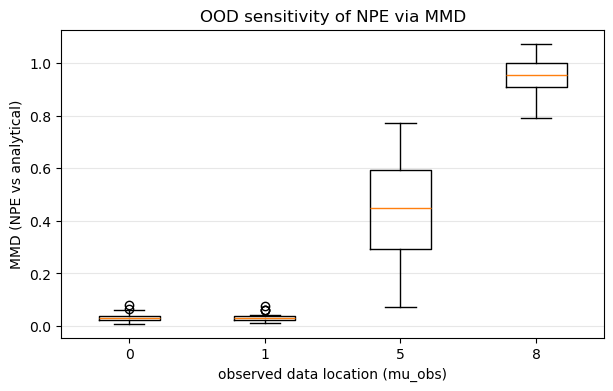

In [29]:
# plot boxplot of MMDs
plt.figure(figsize=(7,4))
plt.boxplot([mmd_by_muobs[m] for m in mu_obs_grid],
            labels=[str(m) for m in mu_obs_grid],
            showfliers=True)
plt.xlabel("observed data location (mu_obs)")
plt.ylabel("MMD (NPE vs analytical)")
plt.title("OOD sensitivity of NPE via MMD")
plt.grid(True, axis="y", alpha=0.3)
plt.show()


The MMD grows with increasing distance of the observed data from the prior mean,
indicating that the NPE posterior approximation degrades for more OOD data.

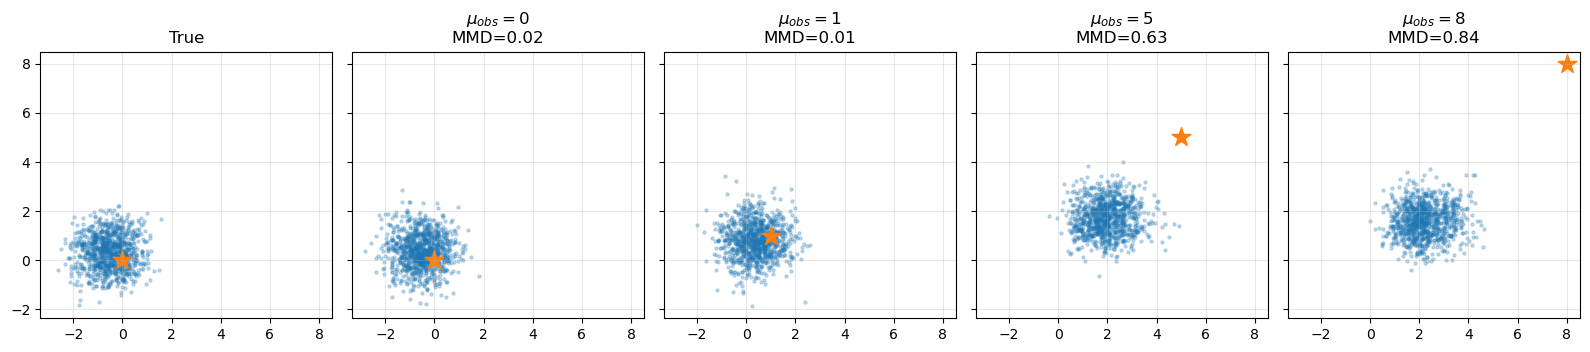

In [30]:
# Visualize posterior samples for different observed data locations
idx = 0  # choose first dataset to display
n_cols = 1 + len(mu_obs_grid)

fig, axes = plt.subplots(
    1, n_cols,
    figsize=(3.2 * n_cols, 3.5),
    sharex=True, sharey=True
)

# True posterior
mu_ref = mu_obs_grid[0]
true_samples_ref = analytical_by_muobs[mu_ref][idx]
theta_star_ref = np.full((D,), mu_ref)

axes[0].scatter(true_samples_ref[:, 0], true_samples_ref[:, 1], s=5, alpha=0.25)
axes[0].scatter(theta_star_ref[0], theta_star_ref[1], marker="*", s=200)
axes[0].set_title("True")

# NPE posterior
for j, mu_obs in enumerate(mu_obs_grid):
    ax = axes[j + 1]

    npe_samples = abi_by_muobs[mu_obs][idx]
    true_samples = analytical_by_muobs[mu_obs][idx]
    theta_star = np.full((D,), mu_obs)

    mmd_one = mmd_rbf_median_heuristic(npe_samples, true_samples)

    ax.scatter(npe_samples[:, 0], npe_samples[:, 1], s=5, alpha=0.25)
    ax.scatter(theta_star[0], theta_star[1], marker="*", s=200)
    ax.set_title(f"$\\mu_{{obs}}={mu_obs}$\nMMD={mmd_one:.2f}")

for ax in axes:
    ax.grid(True, alpha=0.3)
    ax.set_aspect("equal")

plt.tight_layout()
plt.show()


The results show that as the observed data location moves further away from the prior mean (0), the MMD between the NPE posterior samples and the analytical posterior samples increases. This indicates that the NPE method becomes less accurate for OOD observations, highlighting its sensitivity to OOD data. Increasing the training budget might help.

In [31]:
# Utility function: log-mean-exp trick
def logmeanexp(a, axis=None):
    a = np.asarray(a)
    amax = np.max(a, axis=axis, keepdims=True)
    out = amax + np.log(np.mean(np.exp(a - amax), axis=axis, keepdims=True))
    return np.squeeze(out, axis=axis)

In [32]:
# Analytical log marginal likelihood
def log_marginal_analytical(x_obs, mu_prior_mean=0.0, mu_prior_std=1.0, likelihood_std=np.sqrt(K)):
    """
    x_obs: (K, D)
    returns scalar log p(x_obs)
    """
    x_obs = np.asarray(x_obs)

    sig2 = float(likelihood_std**2)         
    tau2 = float(mu_prior_std**2)           
    mu0 = float(mu_prior_mean)

    logdet = (K - 1) * np.log(sig2) + np.log(sig2 + K * tau2)

    xc = x_obs - mu0
    sum_sq = np.sum(xc**2, axis=0)                  
    sum_ = np.sum(xc, axis=0)                     
    quad = (1.0/sig2) * sum_sq - (tau2 / (sig2 * (sig2 + K * tau2))) * (sum_**2)  # (D,)

    logp_per_dim = -0.5 * (K * np.log(2*np.pi) + logdet + quad)  
    return float(np.sum(logp_per_dim))


In [33]:
# NPE log marginal likelihood
def log_prior_mu(mu, mu_prior_mean=0.0, mu_prior_std=1.0):
    """
    mu: (S, D)
    returns (S,)
    """
    mu = np.asarray(mu)
    mu0 = float(mu_prior_mean)
    tau2 = float(mu_prior_std**2)
    prior_density = -0.5 * (D*np.log(2*np.pi*tau2) + np.sum((mu - mu0)**2, axis=1)/tau2)
    return prior_density

def log_likelihood_x_given_mu(x_obs, mu, likelihood_std=np.sqrt(K)):
    """
    x_obs: (K, D)
    mu: (S, D)
    returns (S,)
    """
    x_obs = np.asarray(x_obs)
    mu = np.asarray(mu)
    sig2 = float(likelihood_std**2)
    diff = x_obs[None, :, :] - mu[:, None, :]       # (S, K, D)
    log_likelihood = -0.5 * (K*D*np.log(2*np.pi*sig2) + np.sum(diff**2, axis=(1,2))/sig2)
    return log_likelihood


In [34]:
# NPE log q_phi
def log_q_phi(workflow, mu_samples, x_obs):
    """
    Compute log q_phi(mu | x) for already-sampled mu.

    mu_samples: (S, D)
    x_obs: (K, D)
    returns: (S,)
    """
    mu_samples = np.asarray(mu_samples)
    x_obs = np.asarray(x_obs)

    S = mu_samples.shape[0]
    data = {
        "x": np.repeat(x_obs[None, :, :], S, axis=0)  ,
        "K": np.full((S, 1), K, dtype=np.int32),
        "mu": mu_samples
    }

    out = workflow.approximator.log_prob(data)
    out = np.asarray(out)
    return out.reshape(-1)


In [35]:
# NPE log marginal likelihood
def log_marginal_from_npe_samples(workflow, x_obs, mu_samples,
                                 mu_prior_mean=0.0, mu_prior_std=1.0, likelihood_std=np.sqrt(K)):
    """
    returns scalar log p(x_obs) estimate
    """
    lp = log_prior_mu(mu_samples, mu_prior_mean, mu_prior_std)
    ll = log_likelihood_x_given_mu(x_obs, mu_samples, likelihood_std=likelihood_std)
    lq = log_q_phi(workflow, mu_samples, x_obs)

    log_terms = lp + ll - lq   # (S,)
    log_marginal_npe = logmeanexp(log_terms)
    return float(log_marginal_npe)


In [36]:
logY_true_by_muobs = {}
logY_hat_by_muobs = {}
err_by_muobs = {}

for mu_obs in mu_obs_grid:
    logY_true = np.zeros(num_mmd_datasets, dtype=float)
    logY_hat  = np.zeros(num_mmd_datasets, dtype=float)

    for i in range(num_mmd_datasets):
        x_obs = x_by_muobs[mu_obs][i]          # (K, D)
        mu_s  = abi_by_muobs[mu_obs][i]        # (S, D)

        logY_true[i] = log_marginal_analytical(x_obs, mu_prior_mean=0.0, mu_prior_std=1.0,
                                               likelihood_std=np.sqrt(K))
        logY_hat[i]  = log_marginal_from_npe_samples(workflow, x_obs, mu_s,
                                                     mu_prior_mean=0.0, mu_prior_std=1.0,
                                                     likelihood_std=np.sqrt(K))

    logY_true_by_muobs[mu_obs] = logY_true
    logY_hat_by_muobs[mu_obs] = logY_hat
    err_by_muobs[mu_obs] = logY_hat - logY_true

    print(mu_obs, "median abs error:", np.median(np.abs(err_by_muobs[mu_obs])))


0 median abs error: 0.0010743950509919387
1 median abs error: 0.001577540510076858
5 median abs error: 0.0323733224217122
8 median abs error: 1.0073963202745944


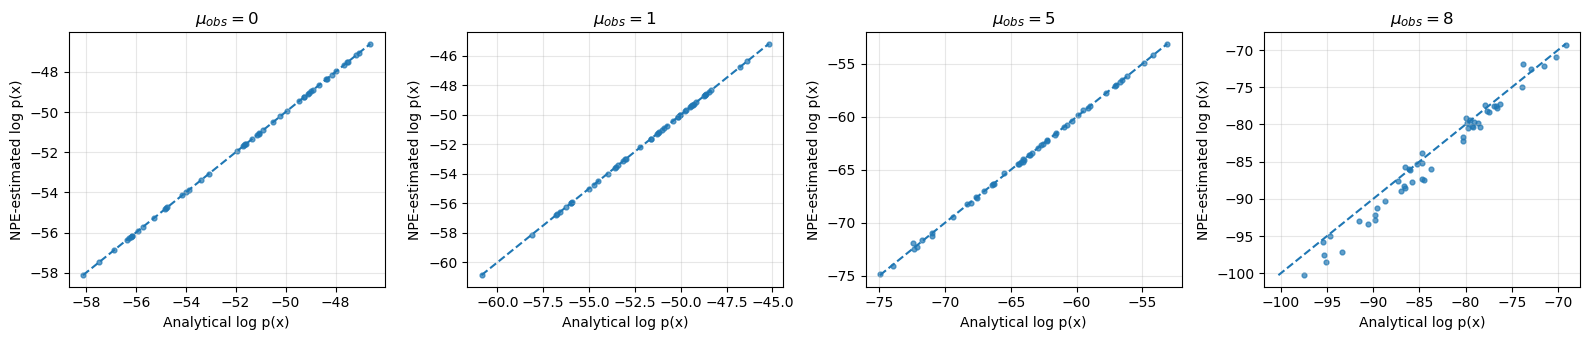

In [37]:
fig, axes = plt.subplots(1, len(mu_obs_grid), figsize=(4*len(mu_obs_grid), 3.5), sharex=False, sharey=False)

for ax, mu_obs in zip(axes, mu_obs_grid):
    x = logY_true_by_muobs[mu_obs]
    y = logY_hat_by_muobs[mu_obs]

    ax.scatter(x, y, s=12, alpha=0.7)
    lo = min(x.min(), y.min())
    hi = max(x.max(), y.max())
    ax.plot([lo, hi], [lo, hi], linestyle="--")  # y=x

    ax.set_title(rf"$\mu_{{obs}}={mu_obs}$")
    ax.set_xlabel("Analytical log p(x)")
    ax.set_ylabel("NPE-estimated log p(x)")
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


/var/folders/l7/b07js_755fb66rkjhmqb78d00000gn/T/ipykernel_30213/2646137860.py:4: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=[str(m) for m in mu_obs_grid], showfliers=True)


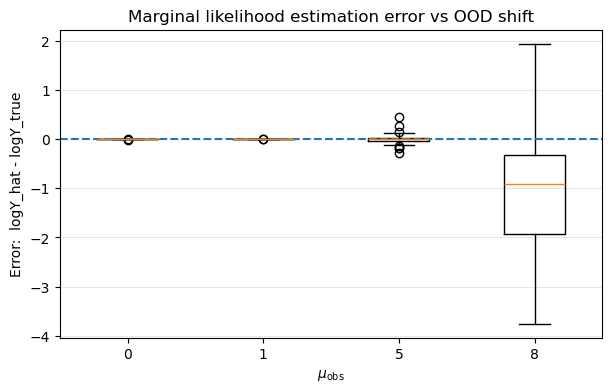

In [38]:
data = [err_by_muobs[m] for m in mu_obs_grid]

plt.figure(figsize=(7, 4))
plt.boxplot(data, labels=[str(m) for m in mu_obs_grid], showfliers=True)
plt.axhline(0.0, linestyle="--")
plt.xlabel(r"$\mu_{\mathrm{obs}}$")
plt.ylabel("Error:  logY_hat - logY_true")
plt.title("Marginal likelihood estimation error vs OOD shift")
plt.grid(True, axis="y", alpha=0.3)
plt.show()
